## Ejercicio 3

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

### Introducción

En este ejercicio, se explora el uso de técnicas de NLP para analizar el primer libro de la serie "Game of Thrones". Se utilizan diferentes métodos de tokenización para procesar el texto y se comparan sus resultados para entender mejor cómo cada enfoque maneja los datos. Este análisis nos permite preparar el texto para modelar embeddings de palabras, lo que nos proporcionará una comprensión más profunda de las relaciones semánticas en el texto.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import os
import re

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise
import numpy as np

import plotly.graph_objects as go
import plotly.express as px

from keras.preprocessing.text import text_to_word_sequence

import nltk

# Descargar diccionario
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Datos

Cargamos el dataset que se encuentra en un archivo de texto, y lo leemos como un DataFrame de pandas.

In [2]:
df = pd.read_csv('./GOT/001ssb.txt', sep='/n', header=None, encoding='latin-1')
df.head()

C:\Users\karen\AppData\Local\Temp\ipykernel_3924\3002682383.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('./GOT/001ssb.txt', sep='/n', header=None, encoding='latin-1')


,0
0,A Game Of Thrones
1,Book One of A Song of Ice and Fire
2,By George R. R. Martin
3,PROLOGUE
4,"""We should start back,"" Gared urged as the woo..."


In [3]:
# Cantidad de filas en los datos
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 19598


Se usa la función text_to_word_sequence de Keras para tokenizar el texto del libro. Esta función nos proporciona una forma sencilla de dividir el texto en palabras individuales.

In [4]:
sentence_tokens = []

# Transformar las oraciones en una secuencia de palabras 
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

# Ver los primeros 5 elementos
sentence_tokens[:5]

[['a', 'game', 'of', 'thrones'],
 ['book', 'one', 'of', 'a', 'song', 'of', 'ice', 'and', 'fire'],
 ['by', 'george', 'r', 'r', 'martin'],
 ['prologue'],
 ['we',
  'should',
  'start',
  'back',
  'gared',
  'urged',
  'as',
  'the',
  'woods',
  'began',
  'to',
  'grow',
  'dark',
  'around',
  'them',
  'the',
  'wildlings',
  'are']]

In [5]:
print("Número de tokens generados por el primer método: ", len(sentence_tokens))

Número de tokens generados por el primer método:  19598


A continuación, se aplica un enfoque más detallado para la tokenización, utilizando NLTK junto con expresiones regulares. Esto nos permite limpiar el texto de caracteres no deseados y realizar una tokenización más precisa.

In [6]:
sentence_tokens_NLTK = []
pattern = r'[^a-zA-z0-9/\'\"s]'

for _, row in df.iterrows():  
    words = re.sub(pattern, ' ', row[0])  # Reemplazar caracteres no deseados con espacios
    words = re.sub(r'[_]', ' ', words)  # Reemplazar guiones bajos con espacios
    words = words.lower()  # Convertir el texto a minúsculas para estandarizar
    sentence_tokens_NLTK.append(nltk.word_tokenize(words))  # Tokenizar el texto y agregar a la lista

# Ver los primeros 5 elementos
print(sentence_tokens_NLTK[:5])

[['a', 'game', 'of', 'thrones'], ['book', 'one', 'of', 'a', 'song', 'of', 'ice', 'and', 'fire'], ['by', 'george', 'r', 'r', 'martin'], ['prologue'], ['``', 'we', 'should', 'start', 'back', '``', 'gared', 'urged', 'as', 'the', 'woods', 'began', 'to', 'grow', 'dark', 'around', 'them', '``', 'the', 'wildlings', 'are']]


In [7]:
print("Número de tokens generados por el método NLTK: ", len(sentence_tokens_NLTK))

Número de tokens generados por el método NLTK:  19598


Comparamos los tokens generados por los dos métodos anteriores. Este análisis nos permite identificar discrepancias y comprender cómo cada enfoque procesa el texto de manera diferente.

In [8]:
# Verificar las diferencias en el procesamiento de las palabras 
dif_words = [] 
q_dif_words = 0  

# Iterar sobre los tokens generados por ambos métodos
for i, j in zip(sentence_tokens, sentence_tokens_NLTK):
    if i != j:
        # Si los tokens de la misma posición son diferentes, compara palabra por palabra
        for l, k in zip(i, j):
            if l != k:
                dif_words.append([l, k])  # Añadir el par de palabras diferentes a la lista
                q_dif_words += 1  # Incrementar el contador de diferencias

            # Si se encontraron más de 10 diferencias, salir del bucle interno
            if q_dif_words > 10:
                break

    # Si se encontraron más de 10 diferencias, salir del bucle externo
    if q_dif_words > 10:
        break    

# Imprimir la cantidad total de pares de palabras diferentes encontradas
print("Total de diferencias encontradas:", len(dif_words))

Total de diferencias encontradas: 11


In [9]:
dif_words

[['we', '``'],
 ['should', 'we'],
 ['start', 'should'],
 ['back', 'start'],
 ['gared', 'back'],
 ['urged', '``'],
 ['as', 'gared'],
 ['the', 'urged'],
 ['woods', 'as'],
 ['began', 'the'],
 ['to', 'woods']]

Analizando los pares de palabras en dif_words, parece que hay una diferencia significativa en cómo cada método de tokenización está manejando el texto. Por ejemplo:

* En varios casos, una palabra en el primer token corresponde a la palabra siguiente en el segundo token, como en ['we', '``'], ['should', 'we'], ['start', 'should']. Esto sugiere que uno de los métodos de tokenización está desfasado en una palabra respecto al otro.

* Las diferencias en la tokenización pueden deberse a cómo cada método trata los caracteres especiales, las comillas, y la puntuación. Por ejemplo, el par ['we', '``'] sugiere que un método está capturando las comillas dobles como un token separado, mientras que el otro no.

### Word2Vec con Gensim

Construimos y entrenamos un modelo Word2Vec utilizando la biblioteca Gensim. Word2Vec es un grupo de modelos relacionados que se utilizan para producir word embeddings, es decir, representaciones vectoriales de palabras. Estos modelos son redes neuronales de dos capas entrenadas para reconstruir contextos lingüísticos de palabras.

In [10]:
# Definición de la clase callback para monitorear la pérdida durante el entrenamiento
class callback(CallbackAny2Vec):
    """
    Clase callback para imprimir la pérdida ('loss') después de cada época de entrenamiento.
    Esta clase se utiliza para obtener información detallada sobre el proceso de aprendizaje
    del modelo y ajustar parámetros si es necesario.
    """
    def __init__(self):
        self.epoch = 0  # Inicializa el contador de épocas
        self.loss_previous_step = 0  # Inicializa la pérdida en el paso anterior

    def on_epoch_end(self, model):
        # Método llamado al final de cada época
        loss = model.get_latest_training_loss()  # Obtiene la pérdida más reciente del modelo
        if self.epoch == 0:
            print(f'Loss after epoch {self.epoch}: {loss}')
        else:
            # Calcula la pérdida desde la última época
            print(f'Loss after epoch {self.epoch}: {loss - self.loss_previous_step}')
        self.epoch += 1  # Incrementa el contador de épocas
        self.loss_previous_step = loss  # Actualiza la pérdida anterior para la próxima comparación

Para nuestro modelo, elegimos la estructura Skipgram de Word2Vec. A diferencia del modelo CBOW (Continuous Bag of Words), Skipgram predice las palabras de contexto a partir de una palabra objetivo, lo que suele ser más efectivo para conjuntos de datos más grandes y con palabras menos frecuentes.

In [11]:
# Creación del modelo Word2Vec utilizando la estructura de modelo Skipgram
w2v_model = Word2Vec(
    min_count=5,    # Frecuencia mínima de palabra para ser incluida en el vocabulario
    window=2,       # Cantidad de palabras antes y después de la palabra objetivo para considerar en el contexto
    vector_size=300, # Dimensionalidad de los vectores de palabras
    negative=20,    # Cantidad de "negative samples" (muestra de palabras no relacionadas); 0 significa que no se usa
    workers=1,      # Cantidad de hilos de procesamiento para entrenar el modelo (ajustar según la máquina)
    sg=1)            # Define el algoritmo de entrenamiento: 0 para CBOW, 1 para Skipgram

In [13]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [14]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 19598


In [15]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 4271


#### Entrenamiento del modelo Word2Vec

Procedemos al entrenamiento de nuestro modelo Word2Vec utilizando los datos procesados anteriormente. El objetivo es aprender representaciones vectoriales (embeddings) de palabras basadas en el contexto en el que aparecen en el texto.

In [16]:
# Iniciamos el proceso de entrenamiento del modelo Word2Vec.
w2v_model.train(sentence_tokens,
                total_examples=w2v_model.corpus_count,  # Total de ejemplos en el corpus. Necesario para la normalización durante el entrenamiento.
                epochs=30,  # Número de iteraciones sobre el corpus.
                compute_loss=True,  # Habilita el cálculo de la pérdida para monitorizar el entrenamiento.
                callbacks=[callback()]  # Usa la clase 'callback' definida anteriormente para imprimir la pérdida después de cada época.
                )

Loss after epoch 0: 2333731.5
Loss after epoch 1: 1640264.0
Loss after epoch 2: 1536486.5
Loss after epoch 3: 1507902.5
Loss after epoch 4: 1484758.5
Loss after epoch 5: 1419290.0
Loss after epoch 6: 1402288.0
Loss after epoch 7: 1384360.0
Loss after epoch 8: 1368254.0
Loss after epoch 9: 1355674.0
Loss after epoch 10: 1342299.0
Loss after epoch 11: 1284900.0
Loss after epoch 12: 1272882.0
Loss after epoch 13: 1257052.0
Loss after epoch 14: 1247500.0
Loss after epoch 15: 1234604.0
Loss after epoch 16: 1222230.0
Loss after epoch 17: 1213892.0
Loss after epoch 18: 1205666.0
Loss after epoch 19: 1194686.0
Loss after epoch 20: 1184294.0
Loss after epoch 21: 1177322.0
Loss after epoch 22: 1170474.0
Loss after epoch 23: 1165622.0
Loss after epoch 24: 1152232.0
Loss after epoch 25: 1126652.0
Loss after epoch 26: 1115016.0
Loss after epoch 27: 1116008.0
Loss after epoch 28: 1109392.0
Loss after epoch 29: 1101296.0


(6179997, 8833650)

#### Exploración de palabras en el modelo Word2Vec

Después de entrenar el modelo Word2Vec, exploramos las palabras en el vocabulario para entender mejor qué ha aprendido el modelo. Para ello, accedemos a una porción del vocabulario generado.

In [21]:
w2v_model.wv.index_to_key[100:120]

['dany',
 'sansa',
 'then',
 'stark',
 'yet',
 'robb',
 'head',
 'too',
 'away',
 'made',
 'where',
 'through',
 'how',
 'lady',
 'robert',
 'took',
 'come',
 'thought',
 'sword',
 'must']

In [23]:
# Palabras que más se relacionan con:
w2v_model.wv.most_similar(positive=["dany"], topn=10)

[('quaro', 0.4369693398475647),
 ('jofftey', 0.43572384119033813),
 ('wineseller', 0.4347544312477112),
 ('handmaids', 0.4347020387649536),
 ('godswife', 0.42159199714660645),
 ('khal', 0.41718557476997375),
 ('handmaid', 0.41684219241142273),
 ('tub', 0.41408586502075195),
 ('prepare', 0.4084009826183319),
 ('jhiqui', 0.4025002419948578)]

In [24]:
# Palabras que menos se relacionan con:
w2v_model.wv.most_similar(negative=["dany"], topn=10)

[('work', 0.03656015545129776),
 ('battle', 0.030178464949131012),
 ('lion', 0.01600867696106434),
 ('us', 0.013376117683947086),
 ("stark's", 0.01268207561224699),
 ('snapped', 0.010875807143747807),
 ('cailin', 0.009066569618880749),
 ('helm', 0.005734656471759081),
 ('attacked', 0.005489793140441179),
 ('suggested', 0.003457161830738187)]

In [27]:
# También se puede comparar a partir de vectores
vector_dany = w2v_model.wv.get_vector("dany")
w2v_model.wv.most_similar(vector_dany)

[('dany', 1.0),
 ('quaro', 0.4369693398475647),
 ('jofftey', 0.43572384119033813),
 ('wineseller', 0.4347544312477112),
 ('handmaids', 0.4347020387649536),
 ('godswife', 0.42159199714660645),
 ('khal', 0.41718557476997375),
 ('handmaid', 0.41684219241142273),
 ('tub', 0.41408586502075195),
 ('prepare', 0.4084009826183319)]

In [28]:
# Palabras que más se relacionan con:
w2v_model.wv.most_similar(positive=["sansa"], topn=10)

[('jeyne', 0.3897938132286072),
 ('arya', 0.3778018355369568),
 ('shave', 0.36562734842300415),
 ('chewing', 0.36313608288764954),
 ('blinking', 0.3615988790988922),
 ("sansa's", 0.3562685251235962),
 ('hate', 0.35619306564331055),
 ('mordane', 0.3532179594039917),
 ('torrhen', 0.352770060300827),
 ('whimpered', 0.34967440366744995)]

In [29]:
# Palabras que menos se relacionan con:
w2v_model.wv.most_similar(negative=["sansa"], topn=10)

[('earth', 0.0401519276201725),
 ('battle', 0.016070010140538216),
 ('remain', 0.011019005440175533),
 ('cell', 0.003208280075341463),
 ('fingers', 0.003157210536301136),
 ('led', 0.0008215640555135906),
 ('urged', 0.000506899319589138),
 ('hundred', -0.001412404584698379),
 ('built', -0.0049398294650018215),
 ("mummer's", -0.006108582951128483)]

In [30]:
# Palabras que más se relacionan con:
w2v_model.wv.most_similar(positive=["stark"], topn=10)

[("stark's", 0.49943575263023376),
 ('torrhen', 0.4756891429424286),
 ('hornwood', 0.4476150870323181),
 ('curtly', 0.4455956220626831),
 ('heddle', 0.43995338678359985),
 ('ben', 0.4393554627895355),
 ('aback', 0.4209018051624298),
 ('softened', 0.4122371971607208),
 ('returning', 0.40672433376312256),
 ('trap', 0.4054073691368103)]

In [31]:
# Palabras que menos se relacionan con:
w2v_model.wv.most_similar(negative=["stark"], topn=10)

[('earth', 0.03251912072300911),
 ('hit', 0.011604711413383484),
 ('breaking', -0.003987689968198538),
 ('twice', -0.008603110909461975),
 ('picked', -0.01666380651295185),
 ('slaves', -0.019165143370628357),
 ('full', -0.01938457228243351),
 ('within', -0.021111413836479187),
 ('behind', -0.021342484280467033),
 ('giving', -0.02171752229332924)]

In [32]:
# Palabras que más se relacionan con:
w2v_model.wv.most_similar(positive=["robb"], topn=10)

[('benjen', 0.41041576862335205),
 ('rickard', 0.3931111991405487),
 ('miserably', 0.3778532147407532),
 ('donnel', 0.3682020306587219),
 ('mollen', 0.3649804890155792),
 ('companion', 0.3637239634990692),
 ('calmly', 0.36346617341041565),
 ('stiffly', 0.36300694942474365),
 ('reluctantly', 0.36273646354675293),
 ('torrhen', 0.36195164918899536)]

In [33]:
# Palabras que menos se relacionan con:
w2v_model.wv.most_similar(negative=["robb"], topn=10)

[('filled', 0.05154573917388916),
 ('within', 0.02908869832754135),
 ('gave', 0.017065148800611496),
 ('living', 0.010498746298253536),
 ('drank', 0.0066534243524074554),
 ('brazier', 0.005363278556615114),
 ('inside', 0.003462894819676876),
 ('making', 0.0021774035412818193),
 ('agony', 0.0004636581288650632),
 ('line', -0.0012565975775942206)]

#### Reducción de dimensionalidad

Para visualizar cómo se distribuyen y se relacionan las palabras en el espacio vectorial de alta dimensión generado por el modelo Word2Vec, necesitamos reducir la dimensionalidad de estos vectores a un espacio más manejable, típicamente 2D o 3D.

In [36]:
def reduce_dimensions(model, num_dimensions = 2 ):
    """
    Esta función reduce las dimensiones de los vectores de palabras del modelo Word2Vec 
    a un número especificado de dimensiones (por defecto, 2) utilizando t-SNE.
    
    :param model: Modelo Word2Vec del cual obtener los vectores de palabras.
    :param num_dimensions: Número de dimensiones a las que se reducirán los vectores (por defecto, 2).
    :return: Tupla de (vectors, labels), donde 'vectors' son los vectores de palabras reducidos y 'labels' son las etiquetas (palabras) correspondientes.
    """
    
    # Conversión de los vectores de palabras del modelo a un array de NumPy
    vectors = np.asarray(model.wv.vectors)
    # Extracción de las etiquetas (palabras) del modelo
    labels = np.asarray(model.wv.index_to_key)  

    # Creación de un objeto t-SNE y configuración de los componentes (dimensiones) objetivo
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    # Aplicación de t-SNE a los vectores para reducir su dimensionalidad
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

#### Visualización en 2D

Una vez que hemos reducido la dimensionalidad de los vectores de palabras de nuestro modelo Word2Vec, el siguiente paso es visualizar estos vectores en un espacio bidimensional para una mejor interpretación y análisis.

In [48]:
# Graficar los embedddings en 2D

# Reducción de la dimensionalidad de los vectores de palabras del modelo Word2Vec
vecs, labels = reduce_dimensions(w2v_model)

# Definición del número máximo de palabras a visualizar
MAX_WORDS=200

# Creación de una gráfica de dispersión con Plotly Express
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig

A continuación se mencionan algunas observaciones sobre la visualización:

* Agrupaciones de palabras: Las palabras que se agrupan cercanamente podrían usarse en contextos similares dentro del texto. Por ejemplo, "Ned" y "Catelyn", o "Jon", "Arya" y "Sansa" están cerca, esto puede indicar que aparecen en los mismos pasajes o se mencionan juntos.

* Agrupaciones temáticas: Algunas palabras están agrupadas de manera que parece reflejar temas o conceptos, como 'king', 'lord', 'khal', que se relacionan con liderazgo y poder.

* Palabras de movimiento o acción: Palabras como 'looked', 'turned', 'came' y 'took' están cercanas entre sí, lo que sugiere que estas palabras de movimiento o acción se usan en contextos similares.

* Descriptores físicos: Palabras como 'hair', 'black', 'red' y 'white' están próximas, indicando que el modelo las asocia con descripciones físicas o visuales.

* Aislamiento de palabras comunes: Palabras de alto uso y baja especificidad semántica como 'the', 'and', 'in' y 'of' aparecen dispersas por el gráfico o en los bordes, lo que refleja su uso generalizado en múltiples contextos.

* Relaciones Posibles: La proximidad entre ciertos nombres y términos podría indicar relaciones o interacciones narrativas, como la cercanía entre 'Ned' y 'lady' o 'Robb' y 'king'.

In [38]:
# Guardar vectores y etiquetas para visualización 

# Extracción de los vectores y labels del modelo Word2Vec
vectors = np.asarray(w2v_model.wv.vectors)  # Convierte los vectores a un array de NumPy
labels = list(w2v_model.wv.index_to_key)     # Obtiene la lista de palabras (etiquetas) del vocabulario

# Guardar los vectores en un archivo .tsv
np.savetxt("./vectors.tsv", vectors, delimiter="\t")

# Guardar las etiquetas en un archivo .tsv
# Creamos un archivo TSV para las etiquetas y escribimos cada etiqueta en una nueva línea.
with open("./labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

In [39]:
# Función para graficar la matriz de similaridad
def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, 
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

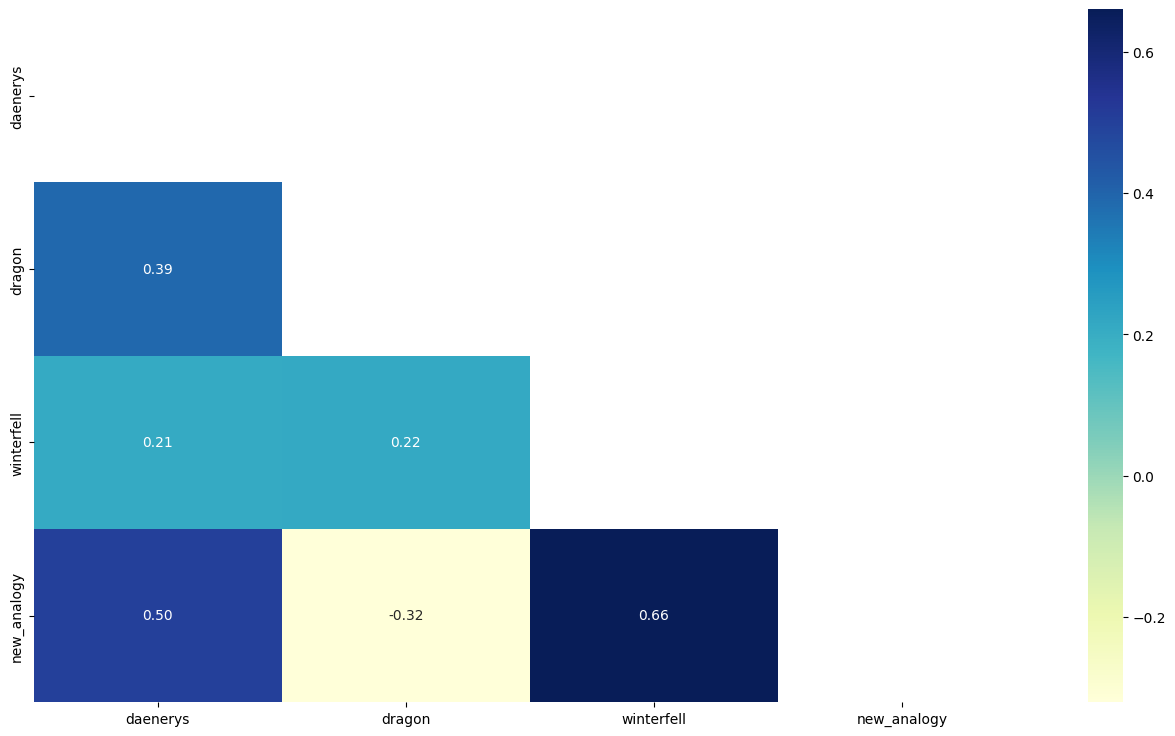

In [42]:
# Definición de las palabras para realizar el test de analogía
test_words = ['daenerys', 'dragon', 'winterfell']

# Inicializamos una lista para almacenar los vectores de embeddings de las palabras seleccionadas
test_emb = []
for word in test_words:
    # Para cada palabra en 'test_words', obtenemos su vector de embedding del modelo Word2Vec
    # y lo añadimos a la lista 'test_emb'
    test_emb.append(w2v_model.wv.get_vector(word))
    
# Realizamos una operación de analogía vectorial: 
# En este caso, es similar a buscar un concepto que se relacione con 'Daenerys' y 'winterfell' 
# de la misma manera que 'dragon' se relaciona con 'Daenerys'.
new_vector = test_emb[0] - test_emb[1] + test_emb[2]

# Agregamos el resultado de la operación de analogía a la lista de palabras y vectores para análisis
new_words = test_words + ['new_analogy']
new_emb = np.append(test_emb, new_vector.reshape(1, -1), axis=0)

# Calculamos la similaridad del coseno entre todos los pares de vectores en 'new_emb'
dist = pairwise.cosine_similarity(new_emb, new_emb)

# Utilizamos la función 'plot_matrix_distance' para graficar la matriz de similaridad
# Esta visualización nos ayudará a entender cómo se relacionan estas palabras y la analogía resultante en el espacio semántico.
plot_matrix_distance(new_words, dist)

La matriz de similaridad muestra las relaciones semánticas entre varias palabras y un vector de analogía ("new_analogy") calculado a partir de ellas.

Los valores de similaridad representados en la matriz se pueden interpretar de la siguiente manera:

* Daenerys y Dragon (0.39): Este valor indica una similaridad moderada entre 'Daenerys' y 'dragon'. Esto tiene sentido narrativo ya que Daenerys es conocida como la "Madre de Dragones".

* Daenerys y Winterfell (0.21): La similaridad entre 'Daenerys' y 'Winterfell' es menos fuerte que con 'dragon'. Esto podría reflejar que, en el universo narrativo, Daenerys tiene una conexión menos directa con Winterfell.

* Dragon y Winterfell (0.22): Un valor similar al anterior, indicando que 'dragon' y 'Winterfell' también tienen una conexión semántica más débil. Esto es lógico, ya que los dragones están más asociados con Daenerys y la cultura Targaryen que con Winterfell.

New_analogy:

* Con Daenerys (0.50): Este es el valor más alto de similaridad en la matriz, indicando que el vector resultante de la analogía guarda una fuerte relación con 'Daenerys'. Esto sugiere que el vector "new_analogy" conserva gran parte de la semántica asociada con Daenerys.

* Con Dragon (-0.32): El valor negativo implica que la operación de analogía ha producido un vector que se aleja semánticamente del concepto de 'dragon'. Esto puede ser el resultado de restar el vector 'dragon' en la operación de analogía.

* Con Winterfell (0.66): Este valor indica que el vector "new_analogy" tiene una fuerte similaridad con 'Winterfell', incluso más que con 'Daenerys'. Esto podría sugerir que el vector captura un concepto que es significativamente relevante para Winterfell o que tiene una fuerte asociación con él en el texto.

Para identificar palabras que tienen una alta similaridad con un concepto representado por new_vector, realizamos lo siguiente:

In [46]:
# Calculamos la similaridad del coseno entre cada vector de palabra en el modelo Word2Vec y el 'new_vector'
similarities = np.squeeze(pairwise.cosine_similarity(w2v_model.wv.vectors,np.array([new_vector])))

# Ordenamos los índices de las similaridades de mayor a menor y seleccionamos los 10 índices principales.
args_sorted = np.argsort(similarities)[::-1][:10]

# Imprimimos las palabras correspondientes a los 10 índices principales y sus valores de similaridad.
for arg in args_sorted:
  print(f'{w2v_model.wv.index_to_key[arg]}: {similarities[arg]}')

winterfell: 0.6603627800941467
daenerys: 0.50272536277771
winterfell's: 0.35820382833480835
joff: 0.35556739568710327
foster: 0.35182878375053406
amusing: 0.34843698143959045
benjen: 0.3402685821056366
bannerman: 0.3378411531448364
blindly: 0.33662185072898865
married: 0.33491072058677673


Los resultados muestran las palabras del vocabulario del modelo que están más "cerca" semánticamente del new_vector. Las palabras con valores de similaridad más altos pueden tener una conexión temática o contextual fuerte con el concepto que new_vector representa.